# 

In [1]:
import os
import re
import json
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import optimize 
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import utils
from utils.plot import plot_traces_nb as plot_traces
from utils.plot import add_cmap


root_dir_walk = os.walk('..')

all_traces_summaries = []


for dirpath, dirnames, filenames in root_dir_walk:
    if (e := re.search('\.\./([0-9]+)', dirpath)) is not None:
        experiment_number = int(e.group(1))
        data = {}
        if 1 <= experiment_number <= 22:
            #if experiment_number not in experiment_configs.keys():
            for filename in filenames:
                fpath = os.path.join(dirpath, filename)
                if re.search('experiment-[0-9]+-per-well-summary\.csv', filename) is not None:
                    all_traces_summaries.append(os.path.join(dirpath, filename))

df  = pd.concat([pd.read_csv(i) for i in all_traces_summaries]).reset_index(drop=True)
df

220    221    222    223    224    225    226    227    228    229  \
0      1.794  2.044  3.500  2.624  2.189  2.374  2.827  2.738  2.903  2.744   
1      2.074  2.132  2.310  3.160  2.696  2.722  2.912  2.637  2.845  2.916   
2      2.010  2.180  2.689  2.782  2.116  2.343  2.567  2.654  2.833  2.749   
3      2.504  2.936  2.576  2.795  2.437  2.560  2.954  2.892  3.443  3.500   
4      2.034  3.500  3.500  3.037  2.474  2.766  3.500  3.500  3.500  3.368   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
16779  2.233  2.388  2.444  2.181  2.215  2.381  2.673  3.500  2.882  2.990   
16780  2.210  3.069  2.670  2.453  2.392  3.255  2.897  2.859  3.500  3.139   
16781  2.264  2.487  3.500  2.914  2.556  3.500  3.337  3.265  3.500  3.500   
16782  2.406  2.699  3.500  3.193  3.187  2.909  3.101  3.500  2.675  2.864   
16783  2.790  3.500  2.538  2.342  2.484  3.500  3.500  3.500  2.853  3.349   

       ...  NaCl / mM  NH4 / mM  BSA /mg/ml  Kpi /mM  Kcl/mM  shaking_seconds  \
0      ...        NaN       NaN         NaN      NaN     NaN              NaN   
1      ...        NaN       NaN         NaN      NaN     NaN              NaN   
2      ...        NaN       NaN         NaN      NaN     NaN              NaN   
3      ...        NaN       NaN         NaN      NaN     NaN              NaN   
4      ...        NaN       NaN         NaN      NaN     NaN              NaN   
...    ...        ...       ...         ...      ...     ...              ...   
16779  ...        NaN       NaN         NaN      NaN     NaN              NaN   
16780  ...        NaN       NaN         NaN      NaN     NaN              NaN   
16781  ...        NaN       NaN         NaN      NaN     NaN              NaN   
16782  ...        NaN       NaN         NaN      NaN     NaN              NaN   
16783  ...        NaN       NaN         NaN      NaN     NaN              NaN   

       BSA  bulk_dispensing  experiments  column  
0      NaN              NaN          NaN     NaN  
1      NaN              NaN          NaN     NaN  
2      NaN              NaN          NaN     NaN  
3      NaN              NaN          NaN     NaN  
4      NaN              NaN          NaN     NaN  
...    ...              ...          ...     ...  
16779  NaN              NaN          NaN     NaN  
16780  NaN              NaN          NaN     NaN  
16781  NaN              NaN          NaN     NaN  
16782  NaN              NaN          NaN     NaN  
16783  NaN              NaN          NaN     NaN  

[16784 rows x 619 columns]

In [2]:
img_dir = 'img_noise'

if not os.path.exists(img_dir):
    os.mkdir(img_dir)

In [3]:
df[[i for i in df.columns if not i.isnumeric()]].T

0                 1                 2      \
experiment_number                     5                 5                 5   
protein_concentration              4.01              4.01              4.01   
plate_type                 Corning 3660      Corning 3660      Corning 3660   
file                   20190619_boi.CSV  20190619_boi.CSV  20190619_boi.CSV   
ligand                              NaN               NaN               NaN   
concentration                     500.0             250.0             125.0   
control                           False             False             False   
address                              A1                C1                E1   
experiment                            5                 5                 5   
block                                 1                 1                 1   
protein_days_thawed                 NaN               NaN               NaN   
centrifuge_rpm                      NaN               NaN               NaN   
centrifuge_minutes                  NaN               NaN               NaN   
dispense_ligands                    NaN               NaN               NaN   
well_volume                         NaN               NaN               NaN   
dispense_bulk                       NaN               NaN               NaN   
picklist                            NaN               NaN               NaN   
k                                   NaN               NaN               NaN   
% DMSO                              NaN               NaN               NaN   
concentrations                      NaN               NaN               NaN   
hours_before_reading                NaN               NaN               NaN   
percent_dmso                        NaN               NaN               NaN   
Triton  / %                         NaN               NaN               NaN   
DMSO /%                             NaN               NaN               NaN   
Arginine / mM                       NaN               NaN               NaN   
Glucose / mM                        NaN               NaN               NaN   
KPi / mM                            NaN               NaN               NaN   
KCl / mM                            NaN               NaN               NaN   
NaCl / mM                           NaN               NaN               NaN   
NH4 / mM                            NaN               NaN               NaN   
BSA /mg/ml                          NaN               NaN               NaN   
Kpi /mM                             NaN               NaN               NaN   
Kcl/mM                              NaN               NaN               NaN   
shaking_seconds                     NaN               NaN               NaN   
BSA                                 NaN               NaN               NaN   
bulk_dispensing                     NaN               NaN               NaN   
experiments                         NaN               NaN               NaN   
column                              NaN               NaN               NaN   

                                  3                 4                 5      \
experiment_number                     5                 5                 5   
protein_concentration              4.01              4.01              4.01   
plate_type                 Corning 3660      Corning 3660      Corning 3660   
file                   20190619_boi.CSV  20190619_boi.CSV  20190619_boi.CSV   
ligand                              NaN               NaN               NaN   
concentration                      62.5             31.25            15.625   
control                           False             False             False   
address                              G1                I1                K1   
experiment                            5                 5                 5   
block                                 1                 1                 1   
protein_days_thawed                 NaN               NaN               NaN   
cent

In [4]:
print(f"{len(df['well_volume'].dropna()) / len(df):.2%}")

72.45%


In [5]:
# def plot_traces(data, 
#                 ax=None,
#                 lw=0.5,
#                 c='#b4b4b4',
#                 colors=None,
#                 xlim=(220, 800),
#                 ylim=(-0.05, 3.5),
#                 legend_dict = None,
#                 **kwargs):
#     
#     if ax is None:
#         fig, ax = plt.subplots(1, 1, 
#                                figsize=(14, 6),
#                               )
#         
#     for i in tqdm(range(len(data))):
#         row = data.iloc[i, :]
#         ax.plot(row,
#                 lw=lw,
#                 c=c if colors is None else colors[i],
#                 alpha=kwargs.get('alpha'),
#                 )
#         
#     ax.set_xlim(*xlim)
#     ax.set_ylim(*ylim)
#     ax.set_xlabel('Wavelength (nm)')
#     ax.set_ylabel('Absorbance')
#     if (title:=kwargs.get('title')):
#         ax.set_title(title)
#     if isinstance(legend_dict, dict):
#         patch_props = legend_dict.get('patch_props')
#         legend_props = legend_dict.get('legend_props')
#         assert all((patch_props, legend_props)), f"expected 'patch_props':list and 'legend_props': dict in legend_dict\nGot {', '.join(legend_dict.keys())}"
#         handles, labels = ax.get_legend_handles_labels()
#         for patch in patch_props:
#             handles.append(mpatches.Patch(**patch))
#         ax.legend(handles=handles, **legend_props)
#     return ax
#     
# def add_cmap(fig, 
#              ax, 
#              vmin, 
#              vmax,
#              **kwargs):
#     fig.colorbar(
#                     plt.matplotlib.cm.ScalarMappable(
#                                                     plt.matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
#                                                     plt.colormaps['inferno'],
#                                                     ),
#                     ax=ax,
#                     **kwargs
#     )

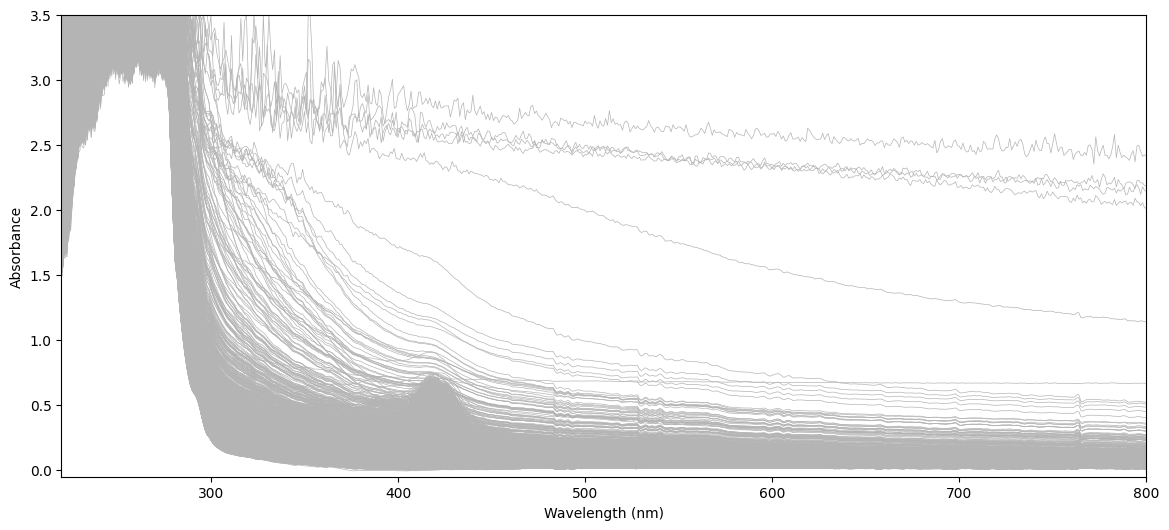

In [6]:
df_data = df[[i for i in df.columns if i.isnumeric()]]
df_data.columns =  df_data.columns.astype(int)
plot_traces(df_data)
plt.show()

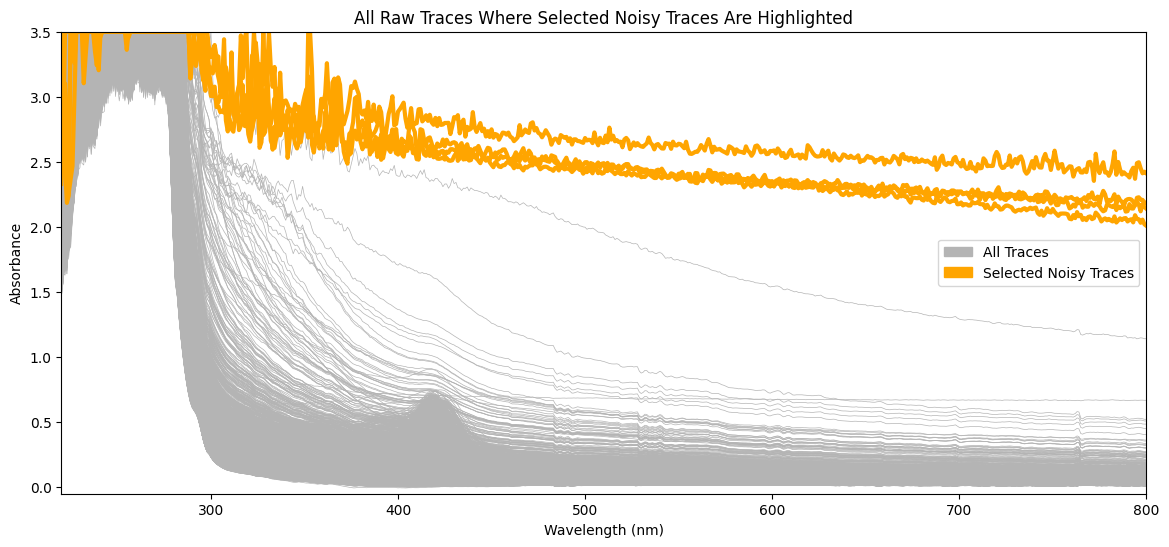

In [7]:
#df_data.loc[df_data[800].argmax(), :]
noisy_traces = df_data.loc[df_data[800].nlargest(4).index, :]

ax = plot_traces(df_data)
plot_traces(noisy_traces,
           ax=ax,
           c='orange',
           lw=3,
           legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                    {'color': 'orange',   'label': 'Selected Noisy Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )
ax.set_title('All Raw Traces Where Selected Noisy Traces Are Highlighted')
plt.savefig(os.path.join(img_dir, 'noisiest-traces-superimposed.png'))
plt.show()

In [8]:
from scipy import signal

noisy_traces_gaus_spline = pd.DataFrame(signal.gauss_spline(noisy_traces, 2), 
                                        columns=noisy_traces.columns,
                                        index=noisy_traces.index,
                                       )
#plot_traces(noisy_traces_gaus_spline)
#plt.show()
noisy_traces_gaus_spline

220           221           222           223           224  \
8154   3.928082e-06  5.431836e-06  3.456500e-09  6.687595e-07  2.312824e-06   
8122   1.826944e-11  1.826944e-11  4.644433e-06  5.689851e-05  3.465899e-05   
11936  1.826944e-11  2.123672e-09  2.130384e-07  4.227523e-07  2.868663e-05   
11904  1.536234e-05  1.083414e-06  1.826944e-11  1.826944e-11  1.826944e-11   

                225           226           227           228           229  \
8154   1.826944e-11  1.826944e-11  1.826944e-11  1.826944e-11  1.826944e-11   
8122   1.826944e-11  1.826944e-11  1.826944e-11  1.826944e-11  1.826944e-11   
11936  1.085191e-05  4.086428e-06  1.402984e-08  1.826944e-11  1.826944e-11   
11904  1.826944e-11  1.826944e-11  4.748827e-10  1.826944e-11  1.826944e-11   

       ...       791       792       793       794       795       796  \
8154   ...  0.000010  0.000006  0.000005  0.000011  0.000003  0.000003   
8122   ...  0.000044  0.000045  0.000053  0.000068  0.000040  0.000039   
11936  ...  0.000062  0.000083  0.000083  0.000062  0.000053  0.000064   
11904  ...  0.000173  0.000166  0.000202  0.000128  0.000163  0.000166   

            797       798       799       800  
8154   0.000005  0.000007  0.000006  0.000007  
8122   0.000046  0.000046  0.000055  0.000058  
11936  0.000100  0.000061  0.000075  0.000084  
11904  0.000207  0.000170  0.000228  0.000249  

[4 rows x 581 columns]

In [9]:
x = pd.DataFrame([
    signal.gauss_spline(noisy_traces.loc[i, :], 0) for i in noisy_traces.index
],
             columns=noisy_traces.columns,
             index=noisy_traces.index,
         )

#plot_traces(x)
#plt.show()


In [10]:
knots = np.array([-1.0, 0.0, -1.0])
signal.gauss_spline(knots, 5)

array([0.20755375, 0.56418958, 0.20755375])

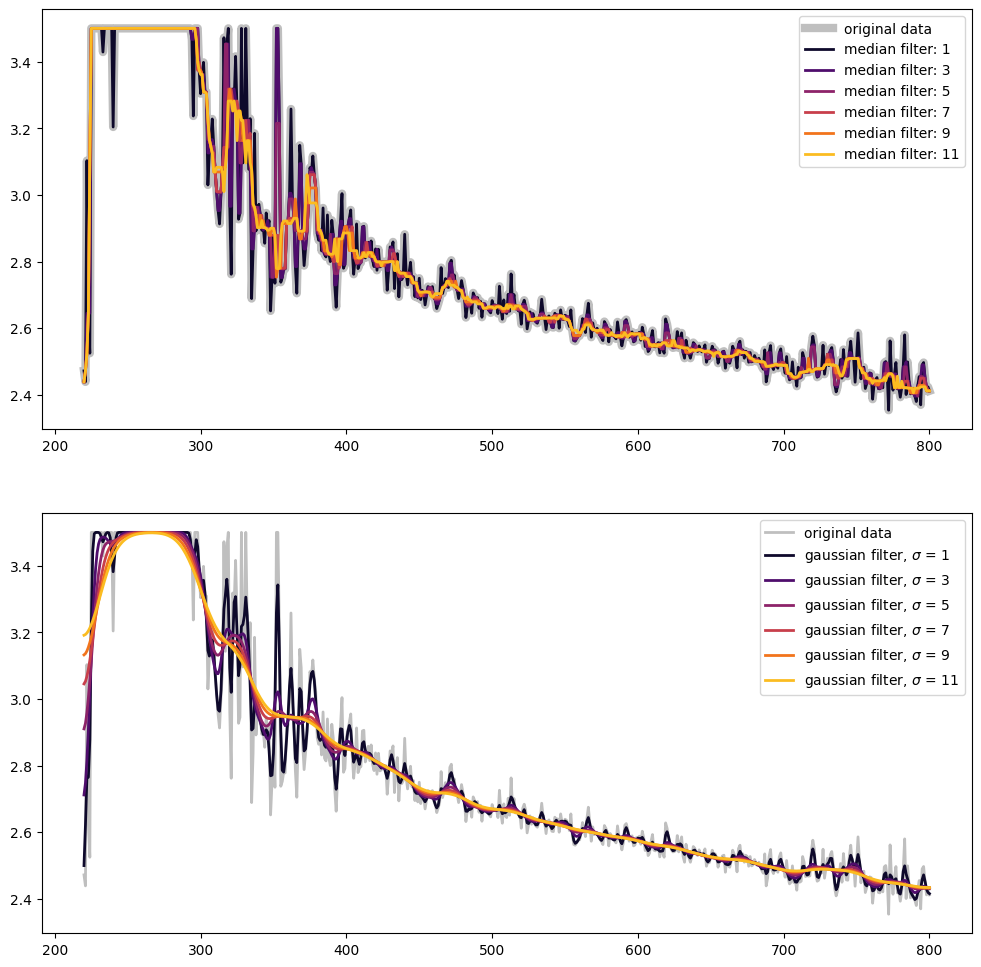

In [11]:
from scipy import ndimage

y = noisy_traces.iloc[0, :]

fig, ax = plt.subplots(2, 1, figsize=(12,12))

n = 12

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

ax[0].plot(y.index, 
           y, 
           c='gray', 
           lw=6, 
           alpha=0.5, 
           label='original data',
          )

#plt.plot(y.index, signal.gauss_spline(y, 2), label='gaus spline')
for i in range(1, n + 1, 2):
   ax[0].plot(y.index, 
              signal.medfilt(y, i), 
              label=f'median filter: {i}',
              c=colors[i],
              lw=2,
             )
ax[0].legend()
    
ax[1].plot(y.index, y, c='gray', lw=2, alpha=0.5, label='original data')
for i in range(1, n + 1, 2):
    ax[1].plot(y.index, 
               ndimage.gaussian_filter1d(y, i), 
               label=f'gaussian filter, $\sigma$ = {i}',
               c=colors[i], 
               lw=2,
              )

ax[1].legend()
plt.show()

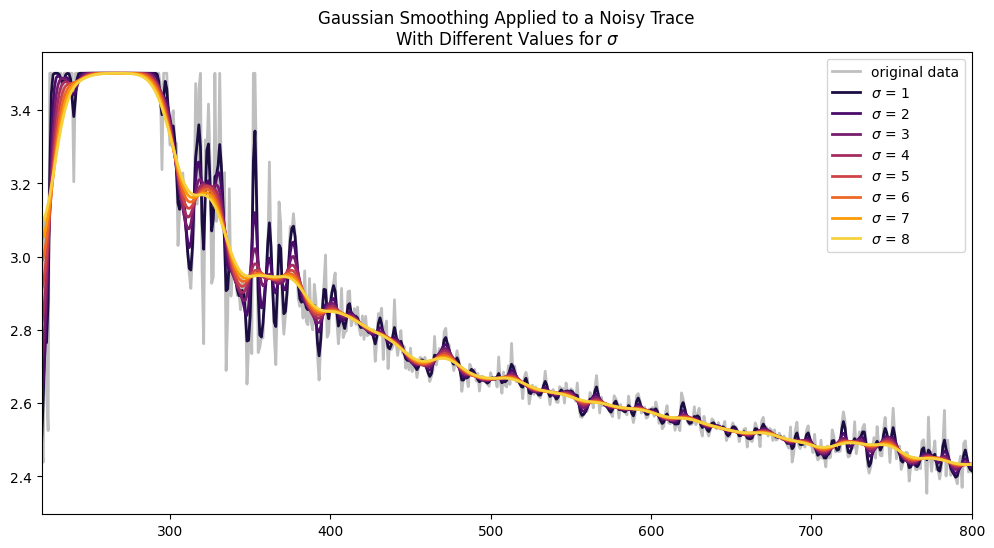

In [12]:
n = 8

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

plt.figure(figsize=(12,6))

plt.plot(y.index, y, c='gray', lw=2, alpha=0.5, label='original data')

for i in range(1, n + 1):
    plt.plot(y.index, 
            ndimage.gaussian_filter1d(y, i), 
            label=f'$\sigma$ = {i}',
            c=colors[i], 
            lw=2,
            )

plt.xlim(220, 800)
#plt.ylim(2, 3.5)
plt.title('Gaussian Smoothing Applied to a Noisy Trace\nWith Different Values for $\sigma$')
plt.legend()
plt.savefig(os.path.join(img_dir, 'gaussian-smoothing-var-sigma.png'))
plt.show()

Int64Index([1046], dtype='int64')


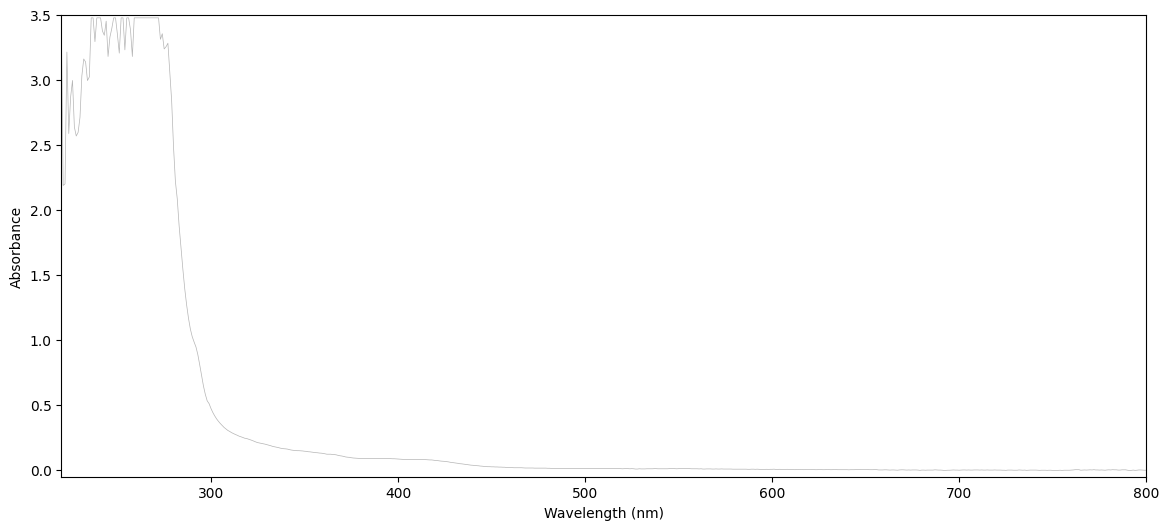

In [13]:
# choosing a protein trace to demo smoothing 13090
protein_data = df.loc[df['control'] == False, :]

protein = protein_data[[i for i in protein_data.columns if i.isnumeric()]]
protein.columns =  protein.columns.astype(int)

protein = protein.subtract(protein[800].values, axis=0).sample()

print(protein.index)
plot_traces(protein)
plt.show()

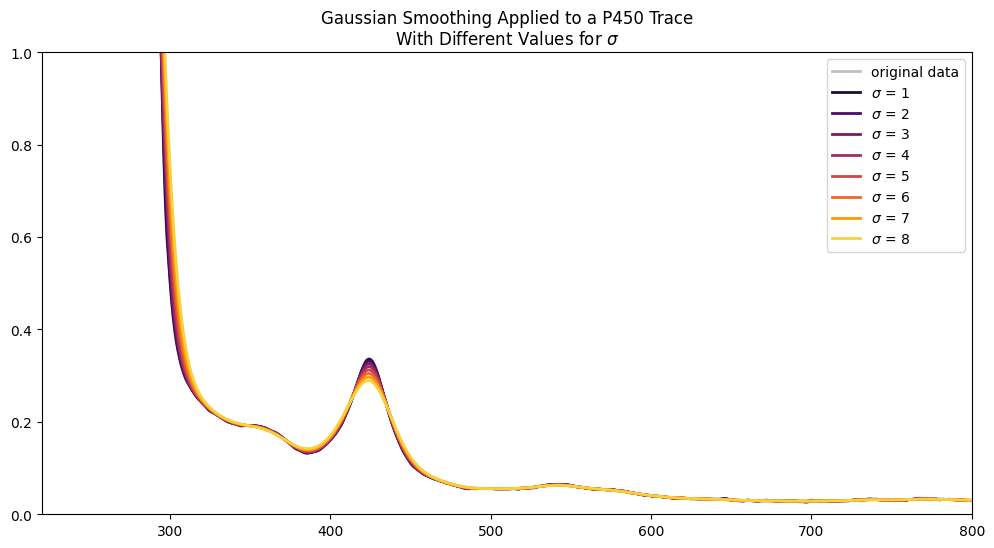

In [14]:
n = 8

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

eg_protein = df_data.loc[13090, :]

plt.figure(figsize=(12,6))

plt.plot(eg_protein.index, eg_protein, c='gray', lw=2, alpha=0.5, label='original data')

for i in range(1, n + 1):
    plt.plot(eg_protein.index, 
            ndimage.gaussian_filter1d(eg_protein, i), 
            label=f'$\sigma$ = {i}',
            c=colors[i], 
            lw=2,
            )

plt.xlim(220, 800)
plt.ylim(0, 1)
#plt.ylim(2, 3.5)
plt.title('Gaussian Smoothing Applied to a P450 Trace\nWith Different Values for $\sigma$')
plt.legend()
plt.savefig(os.path.join(img_dir, 'gaussian-smoothing-p450-var-sigma.png'))
plt.show()

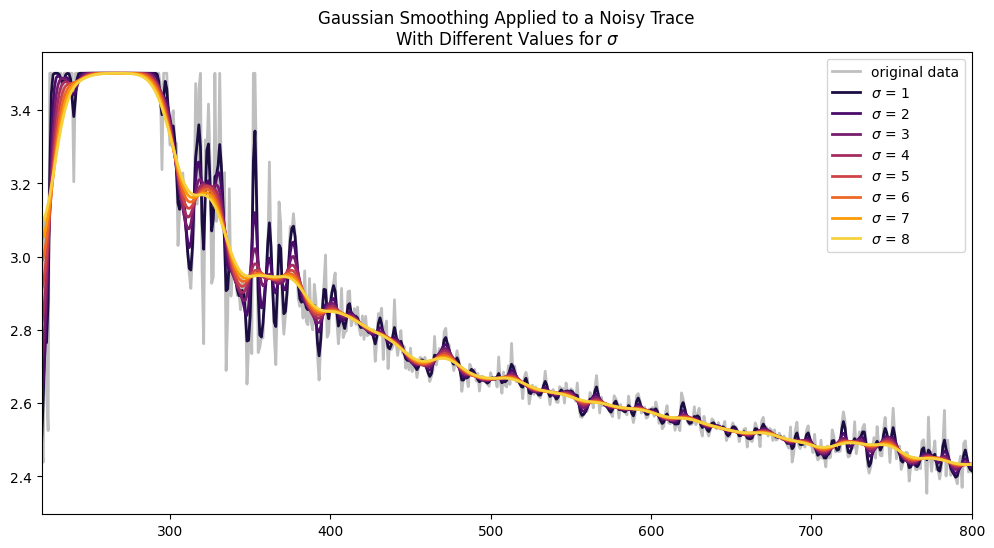

In [15]:
n = 8

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

plt.figure(figsize=(12,6))

plt.plot(y.index, y, c='gray', lw=2, alpha=0.5, label='original data')

for i in range(1, n + 1):
    plt.plot(y.index, 
            ndimage.gaussian_filter1d(y, i), 
            label=f'$\sigma$ = {i}',
            c=colors[i], 
            lw=2,
            )

plt.xlim(220, 800)
#plt.ylim(2, 3.5)
plt.title('Gaussian Smoothing Applied to a Noisy Trace\nWith Different Values for $\sigma$')
plt.legend()
plt.savefig(os.path.join(img_dir, 'gaussian-smoothing-var-sigma.png'))
plt.show()


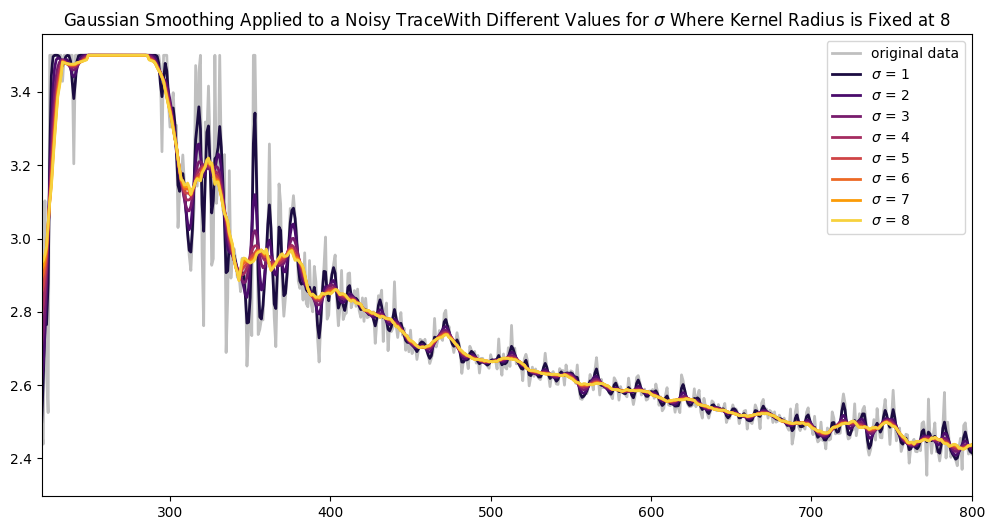

In [16]:
kernel_radius = 8
n = 8

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

plt.figure(figsize=(12,6))

plt.plot(y.index, y, c='gray', lw=2, alpha=0.5, label='original data')

for i in range(1, n + 1):
    plt.plot(y.index, 
            ndimage.gaussian_filter1d(y, sigma=i, radius=kernel_radius), 
            label=f'$\sigma$ = {i}',
            c=colors[i], 
            lw=2,
            )

plt.xlim(220, 800)
#plt.ylim(2, 3.5)
plt.title(f'Gaussian Smoothing Applied to a Noisy Trace\
With Different Values for $\sigma$ Where Kernel Radius is Fixed at {kernel_radius}')
plt.legend()
plt.savefig(os.path.join(img_dir, 'gaussian-smoothing-var-sigma-fix-kernel-radius.png'))
plt.show()

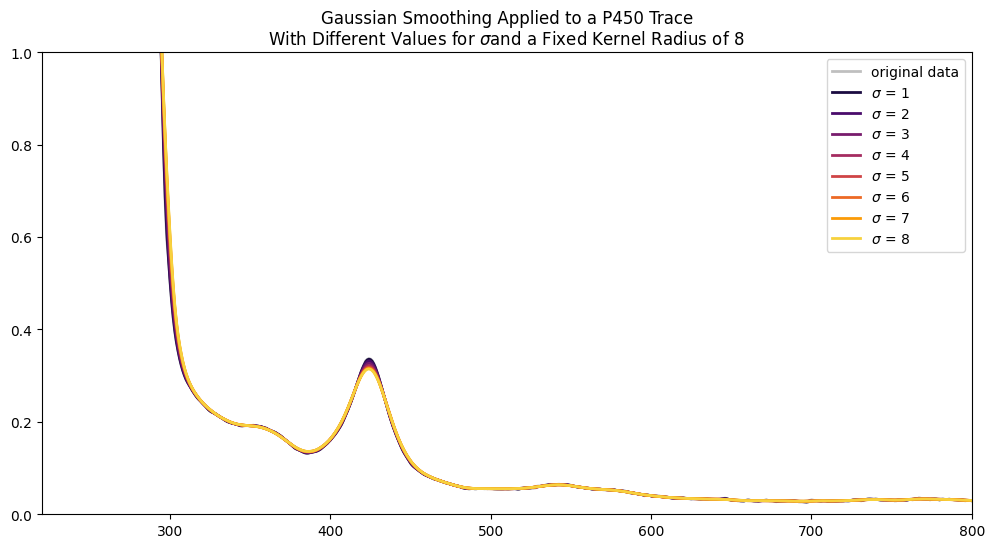

In [17]:
n = 8
kernel_radius = 8

colors = plt.cm.inferno(np.linspace(0, 1, n + 2))

eg_protein = df_data.loc[13090, :]

plt.figure(figsize=(12,6))

plt.plot(eg_protein.index, eg_protein, c='gray', lw=2, alpha=0.5, label='original data')

for i in range(1, n + 1):
    plt.plot(eg_protein.index, 
            ndimage.gaussian_filter1d(eg_protein, sigma=i, radius=kernel_radius), 
            label=f'$\sigma$ = {i}',
            c=colors[i], 
            lw=2,
            )

plt.xlim(220, 800)
plt.ylim(0, 1)
#plt.ylim(2, 3.5)
plt.title(f'Gaussian Smoothing Applied to a P450 Trace\nWith Different Values for $\sigma$\
and a Fixed Kernel Radius of {kernel_radius}')
plt.legend()
plt.savefig(os.path.join(img_dir, 'gaussian-smoothing-p450-var-sigma-fix-kernel-radius.png'))
plt.show()


/home/james/.local/lib/python3.10/site-packages/scipy/ndimage/_filters.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)
/home/james/.local/lib/python3.10/site-packages/scipy/ndimage/_filters.py:195: RuntimeWarning: invalid value encountered in multiply
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)


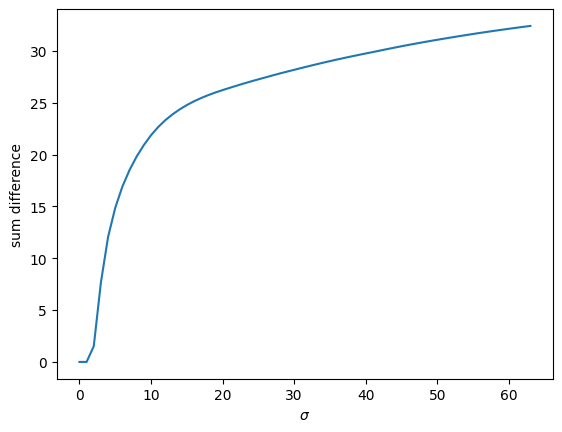

In [18]:
diff_sums = []

x = np.linspace(0, 12, 64)

for i in x:
    yh = pd.Series(ndimage.gaussian_filter1d(y, i),
                   index=y.index,
                  )
    
    diff =  yh - y
    diff_sums.append(diff.abs().sum())

plt.plot(diff_sums)
plt.xlabel('$\sigma$')
plt.ylabel('sum difference')
plt.show()

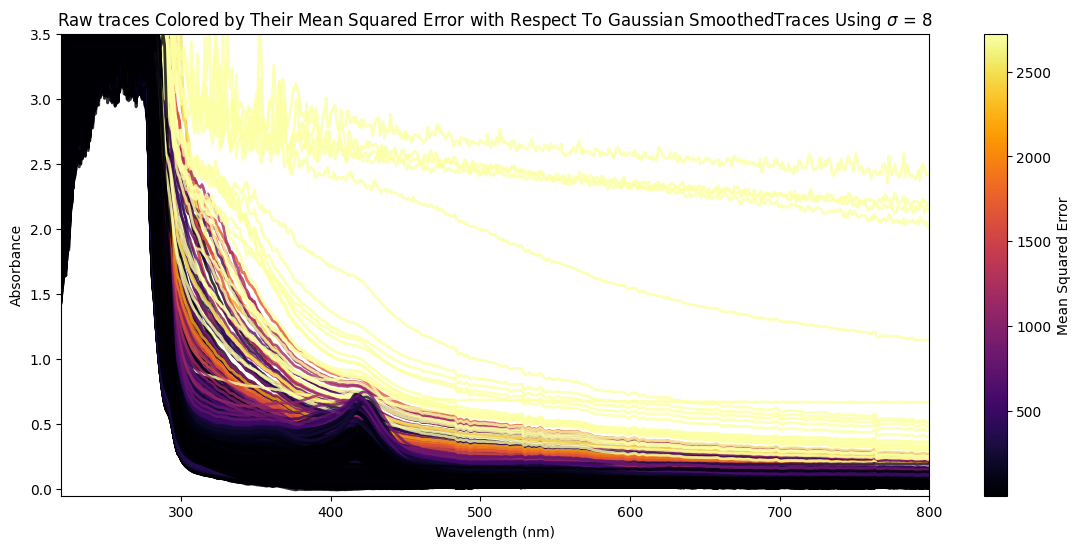

In [19]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler

sigma = 8

yh = pd.DataFrame(
    ndimage.gaussian_filter1d(df_data, sigma=sigma, axis=0),
    index=df_data.index,
    columns=df_data.columns,
)

scaler = StandardScaler()
#scaler = PowerTransformer()
#scaler = RobustScaler()

# diff = (yh.loc[:, 350:] - df_data.loc[:, 350:]).abs().sum(axis=1)
# diff_scaled = scaler.fit_transform(pd.DataFrame(diff))

mse = ((yh.loc[:, 350:] - df_data.loc[:, 350:])**2).sum(axis=1) # mse
mse_scaled = scaler.fit_transform(mse.values.reshape(-1, 1))

#colors = plt.cm.inferno(diff_scaled)
colors_mse = plt.cm.inferno(mse_scaled)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(df_data,
            colors=colors_mse,
            lw=2,
            alpha=0.8,
            ax=ax
           )

add_cmap(fig,
         ax,
         vmin=min(mse),
         vmax=max(mse),
         label='Mean Squared Error',
        )

plt.title(f'Raw traces Colored by Their Mean Squared Error with Respect To Gaussian Smoothed\
Traces Using $\sigma$ = {sigma}')
plt.savefig(os.path.join(img_dir, 'raw-traces-color-mse-smooth.png'))
plt.show()

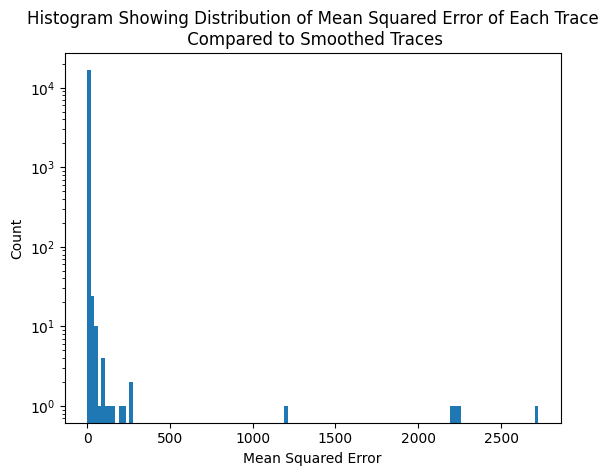

In [20]:
plt.hist(mse, bins=128)
plt.yscale('log')
plt.title('Histogram Showing Distribution of Mean Squared Error of Each Trace\n Compared to Smoothed Traces')
plt.xlabel('Mean Squared Error')
plt.ylabel('Count')
plt.savefig(os.path.join(img_dir, 'hist-mse.png'))
plt.show()

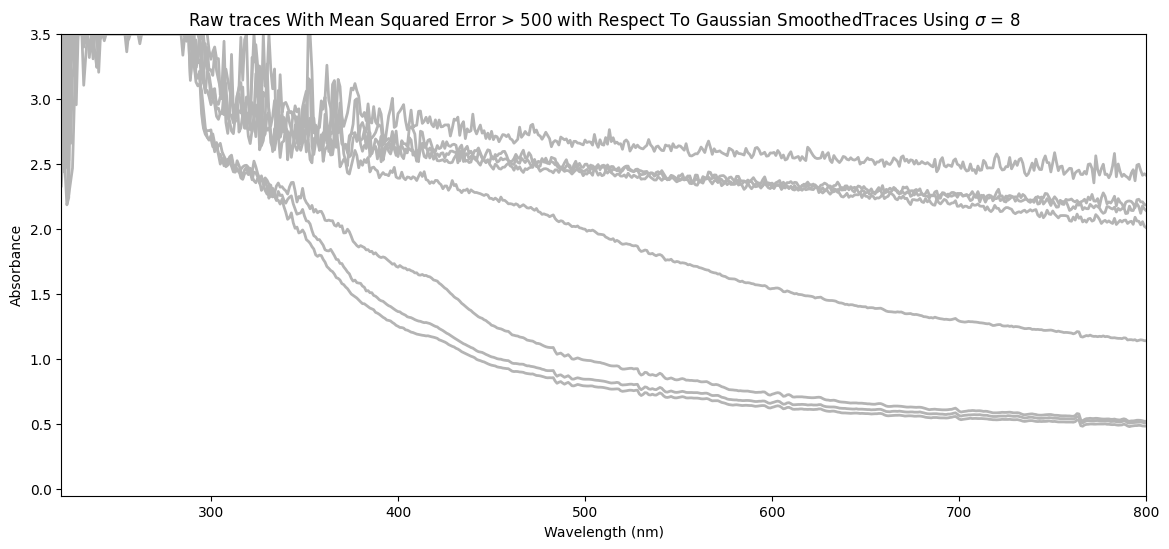

In [21]:
worst_mse = df_data.loc[mse > 200, :]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(worst_mse,
            #colors=colors_mse[worst_mse.index],
            lw=2,
            ax=ax
           )

plt.title(f'Raw traces With Mean Squared Error > 500 with Respect To Gaussian Smoothed\
Traces Using $\sigma$ = {sigma}')
plt.savefig(os.path.join(img_dir, 'raw-traces-worst-mse.png'))
plt.show()

In [22]:
sum(mse < 1) / len(mse)

0.8127383222116301

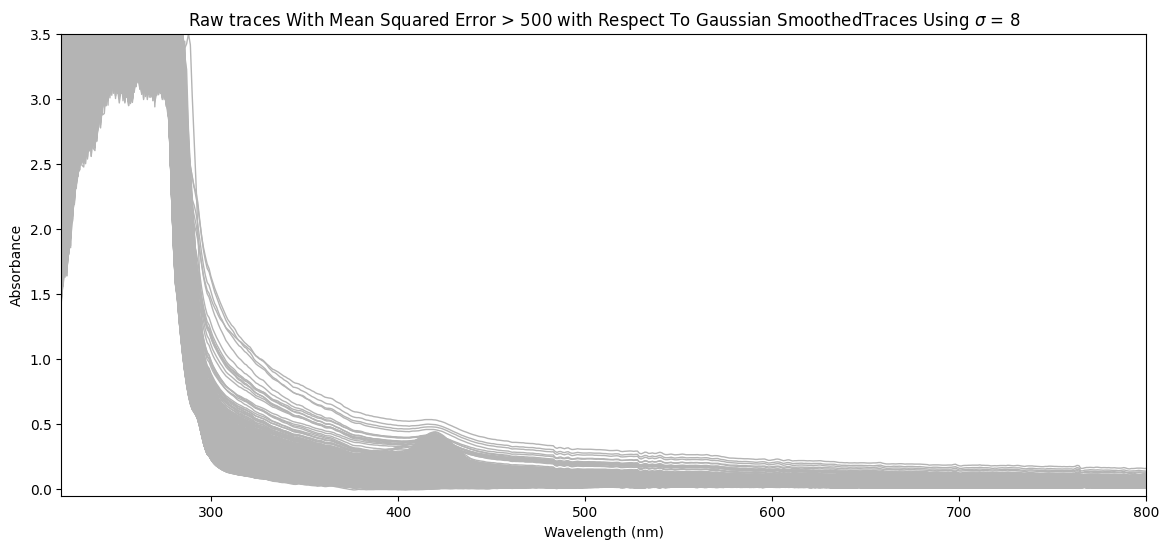

In [23]:
worst_mse = df_data.loc[mse < 1, :]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(worst_mse,
            #colors=colors_mse[worst_mse.index],
            lw=1,
            ax=ax
           )

plt.title(f'Raw traces With Mean Squared Error > 500 with Respect To Gaussian Smoothed\
Traces Using $\sigma$ = {sigma}')
plt.savefig(os.path.join(img_dir, 'raw-traces-worst-mse.png'))
plt.show()


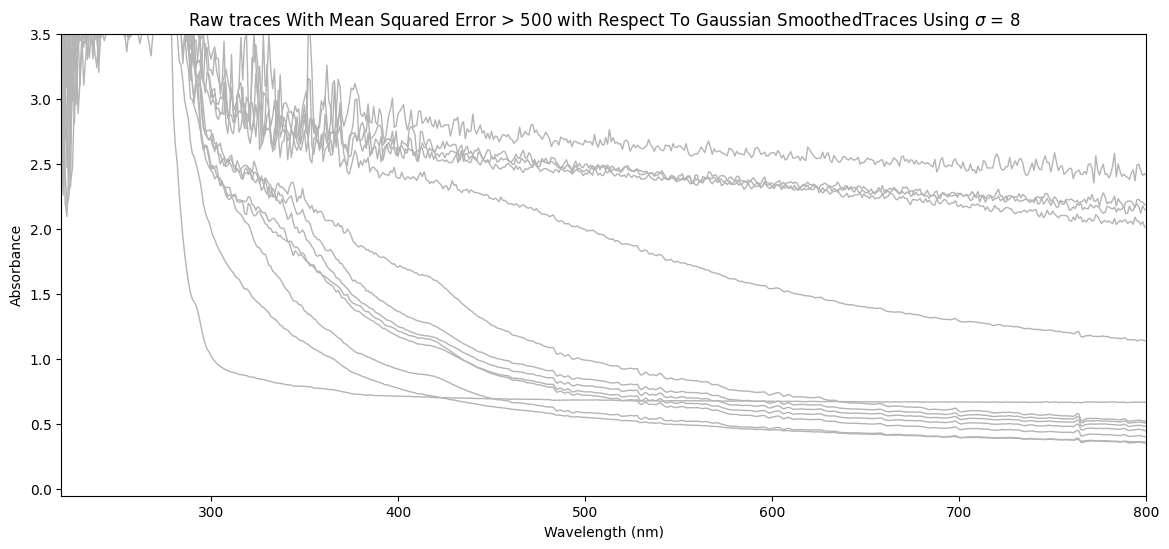

In [24]:
worst_mse = df_data.loc[mse > 100, :]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(worst_mse,
            #colors=colors_mse[worst_mse.index],
            lw=1,
            ax=ax
           )

plt.title(f'Raw traces With Mean Squared Error > 500 with Respect To Gaussian Smoothed\
Traces Using $\sigma$ = {sigma}')
plt.savefig(os.path.join(img_dir, 'raw-traces-worst-mse.png'))
plt.show()

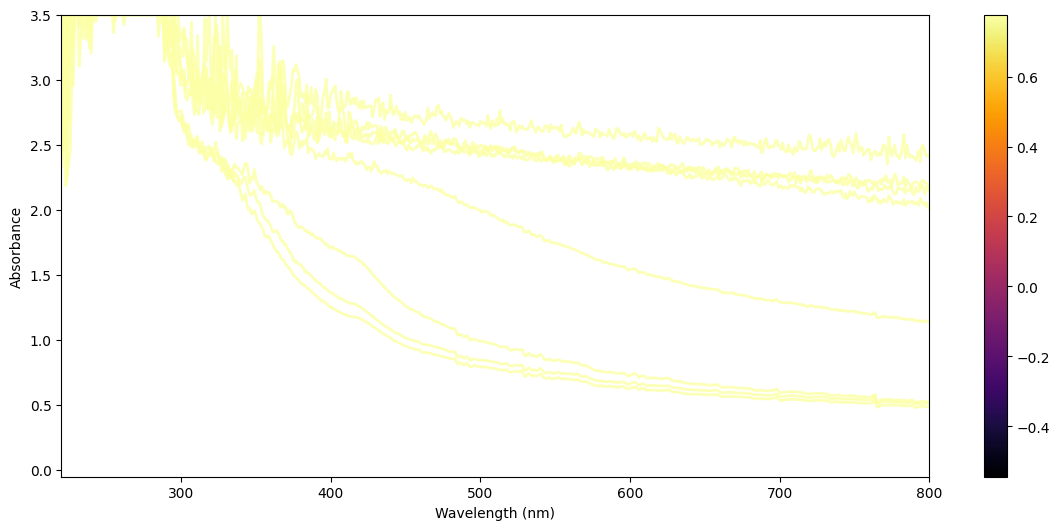

In [25]:
# worst_diffs = diff.nlargest(32)
worst_diffs = mse.loc[mse > 200]
# worst_diffs = diff.loc[diff > 200]

worst_diffs_scaled = scaler.fit_transform(pd.DataFrame(worst_diffs))
colors = plt.cm.inferno(worst_diffs_scaled)

df_data_worst = df_data.loc[worst_diffs.index, :]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(df_data_worst,
            colors=colors_mse[df_data_worst.index],
            lw=2,
            alpha=0.8,
            ax=ax
           )

add_cmap(fig,
         ax,
         vmin=min(diff),
         vmax=max(diff),
        )

plt.show()

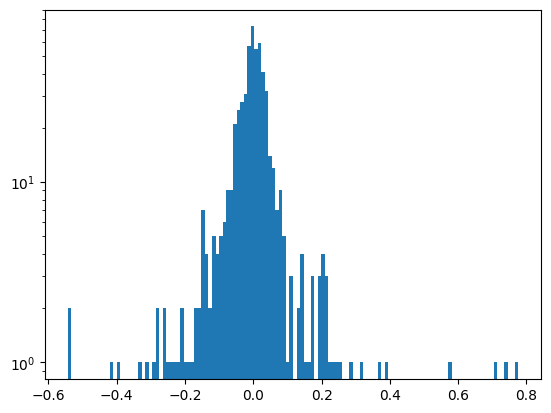

In [26]:
plt.hist(diff, bins=128)
# plt.xscale('log')
plt.yscale('log')
plt.show()

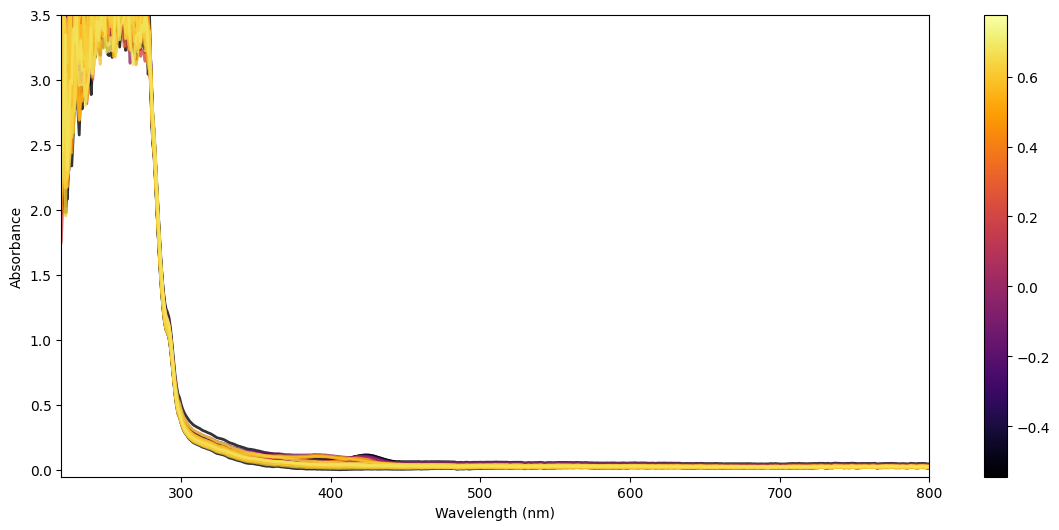

In [27]:
best_diffs = diff.nsmallest(32)

best_diffs_scaled = scaler.fit_transform(pd.DataFrame(best_diffs))
colors = plt.cm.inferno(best_diffs_scaled)

df_data_best = df_data.loc[best_diffs.index, :]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(df_data_best,
            colors=colors,
            lw=2,
            alpha=0.8,
            ax=ax
           )

add_cmap(fig,
         ax,
         vmin=min(diff),
         vmax=max(diff),
        )

plt.show()

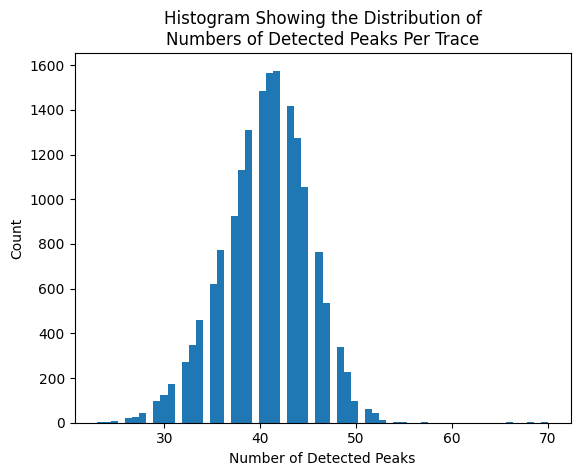

In [28]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks
# I think defaults are fine

peaks =  [
    signal.find_peaks(
        x=df_data.iloc[i, 350:],
        height=None,
        threshold=None,
        distance=1,
        prominence=None,
        width=None,
    )[0]  for i in df_data.index
]
n_peaks = [len(i) for i in peaks]

plt.hist(n_peaks, bins=64)
plt.xlabel('Number of Detected Peaks')
plt.ylabel('Count')
plt.title('Histogram Showing the Distribution of\nNumbers of Detected Peaks Per Trace')
plt.savefig(os.path.join(img_dir, 'hist-n-peaks.png'))
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

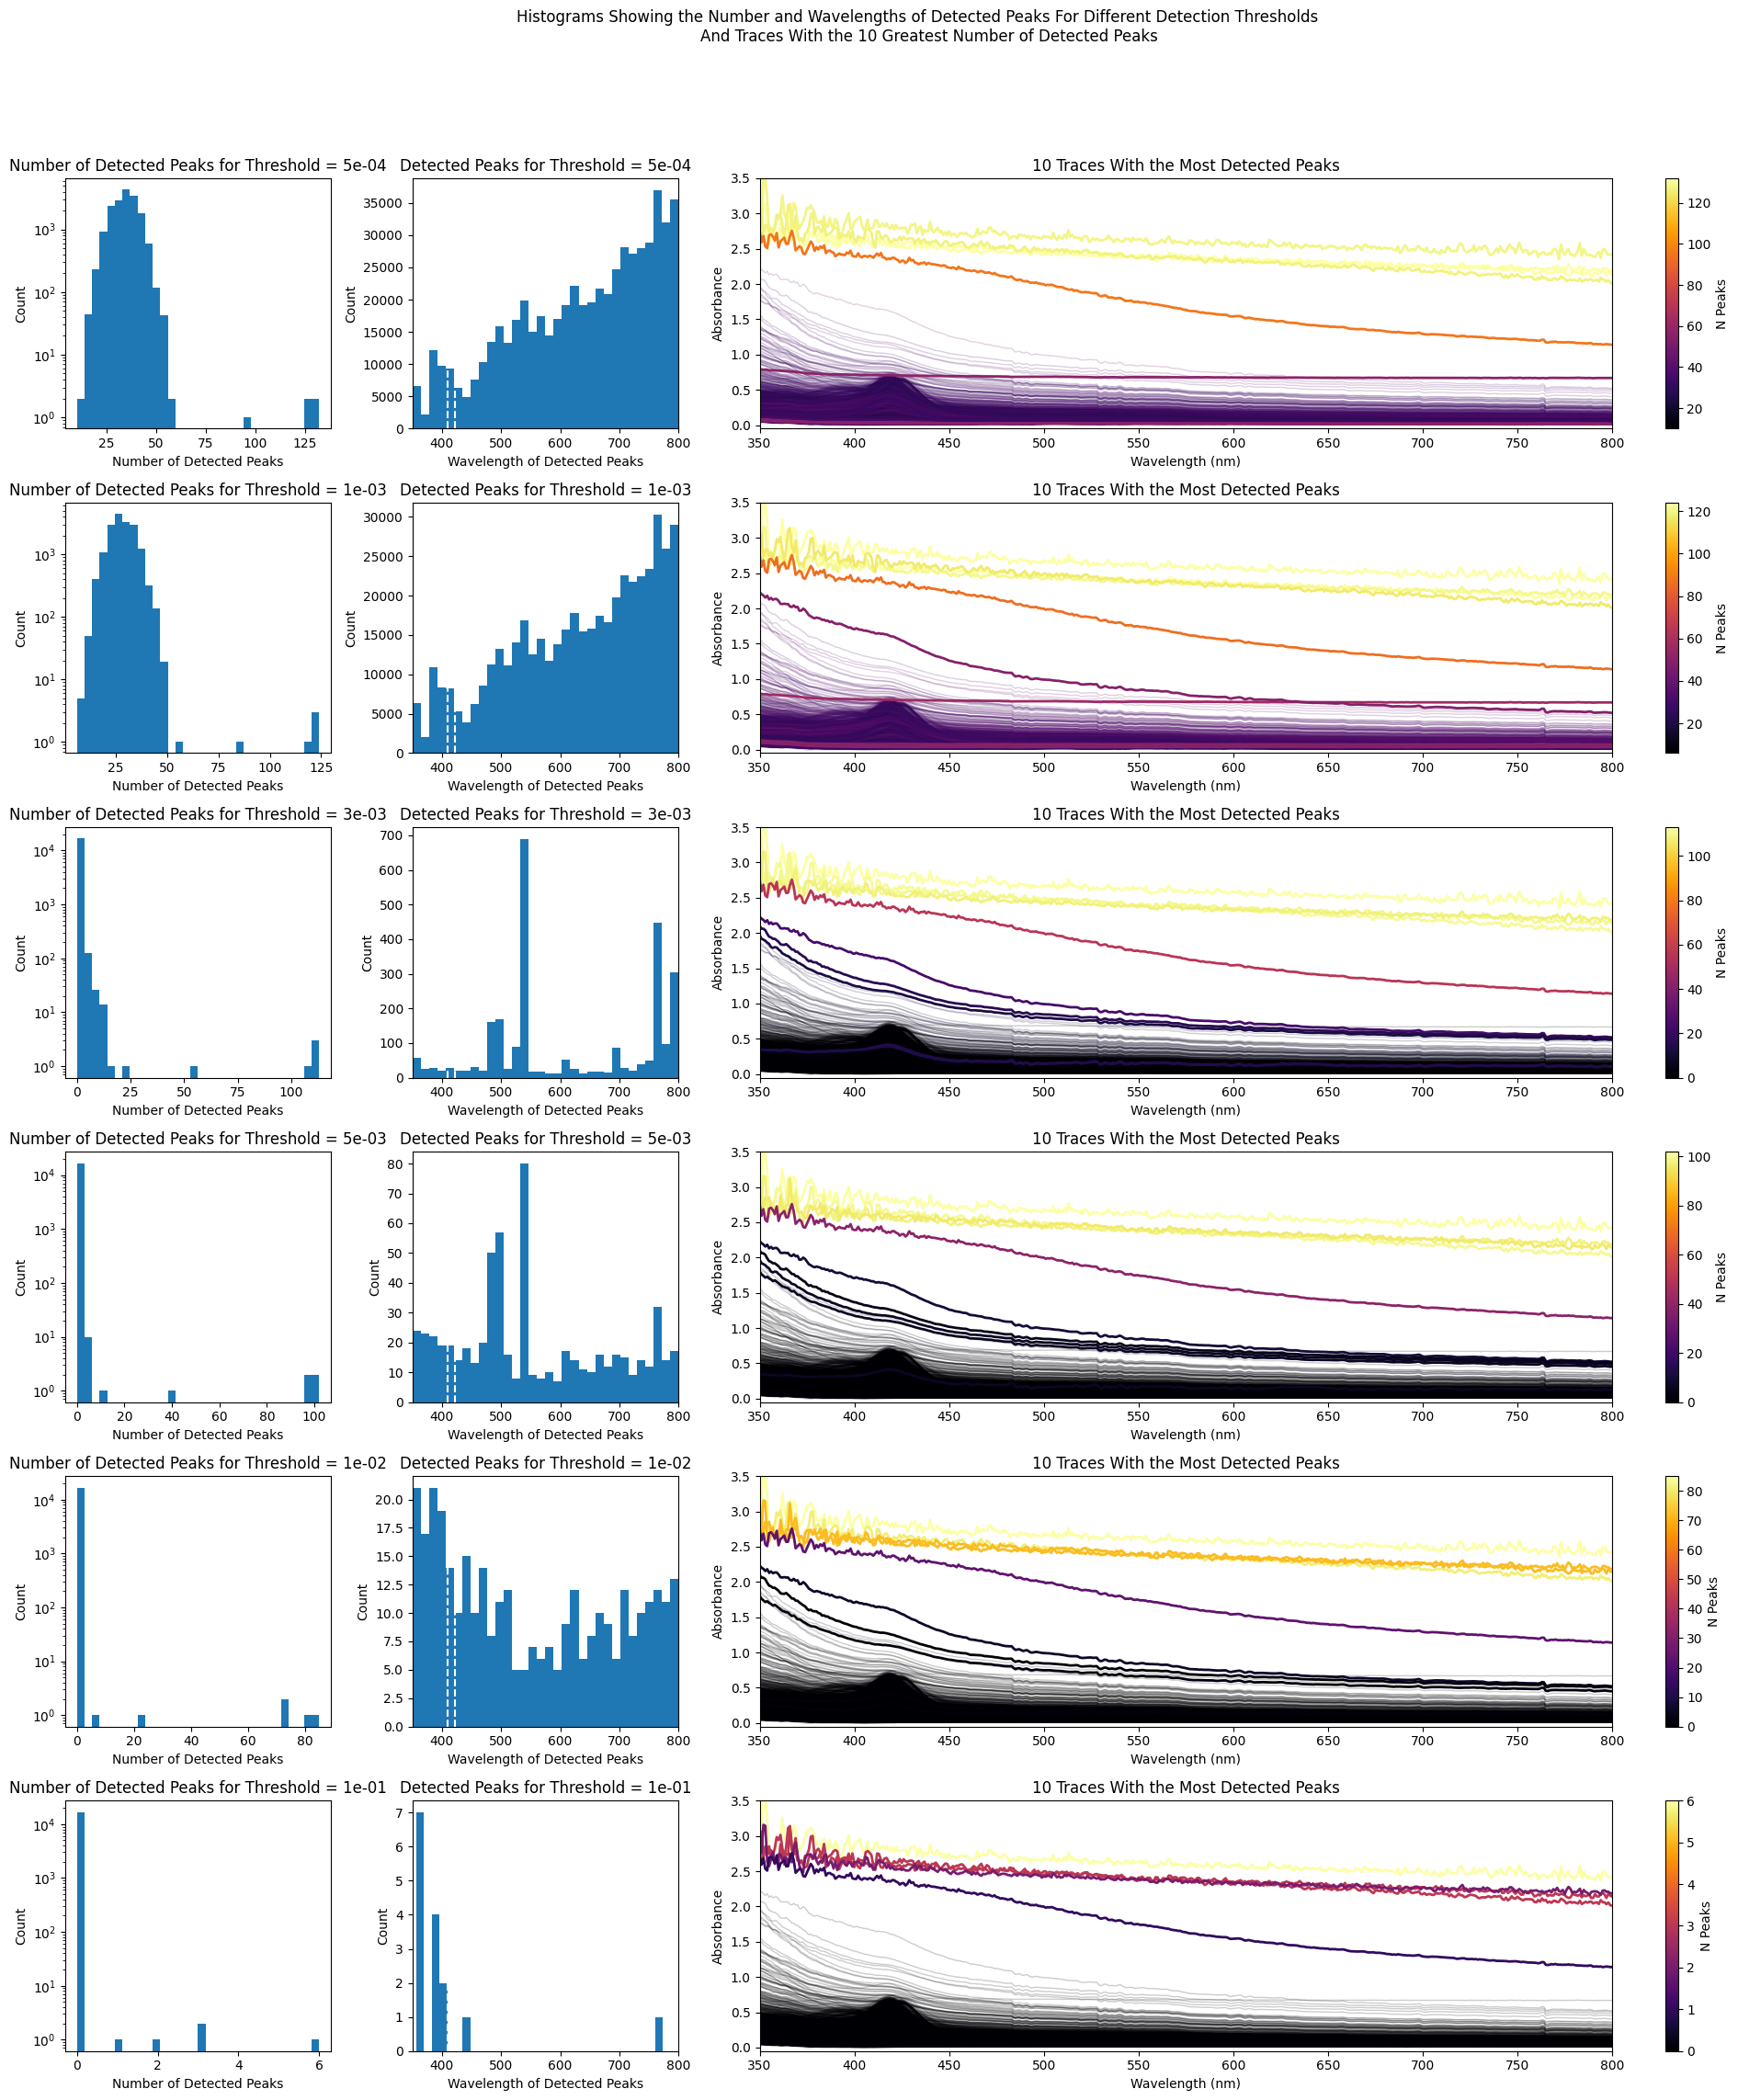

In [71]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks
# I think defaults are fine
from textwrap import dedent

# thresholds = [0.0005, 0.001, 0.005, 0.006, 0.007, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
thresholds = [0.0005, 0.001, 0.003, 0.005, 0.01, 0.1]

n = len(thresholds)

colors = plt.cm.inferno(np.linspace(0, 1, n))

fig, axs = plt.subplots(n, 3, 
                        figsize=(20, 4*n),
                        width_ratios=[1, 1, 4],
                       )

for h, thresh in enumerate(tqdm(thresholds)):
    peaks =  [
        signal.find_peaks(
            x=df_data.loc[i, 350:],
            height=None,
            threshold=thresh,
            distance=1,
            prominence=None,
            width=None,
        )[0]  for i in df_data.index
    ]
    n_peaks = [len(i) for i in peaks]
    
    axs[h, 0].hist(n_peaks, 
                   bins=32, 
                   )
    
    axs[h, 0].set_xlabel('Number of Detected Peaks')
    axs[h, 0].set_ylabel('Count')
    axs[h, 0].set_title(f'Number of Detected Peaks for Threshold = {thresh:.0e}')
    axs[h, 0].set_yscale('log')

    peaks_wavelengths = np.concatenate([df_data.loc[:, 350:].columns[i] for i in peaks])
    _counts, _bins, _ = axs[h, 1].hist(peaks_wavelengths.flatten(),
                   bins=32,
                  )
    axs[h, 1].vlines(409, 0, max(_counts), color='white', linestyle='--') # find ylim for hist
    axs[h, 1].vlines(422, 0, max(_counts), color='white', linestyle='--') # find ylim for hist
    axs[h, 1].set_xlabel('Wavelength of Detected Peaks')
    axs[h, 1].set_xlim(350, 800)
    axs[h, 1].set_ylabel('Count')
    axs[h, 1].set_title(f'Detected Peaks for Threshold = {thresh:.0e}')
    # axs[h, 1].set_yscale('log')

    # plot traces above threshold

    n_peaks = [len(i) for i in peaks]
    n_peaks_ser = pd.Series(n_peaks)
    n_for_n_largest = 16
    n_peaks_nlargest = n_peaks_ser.nlargest(n_for_n_largest)
    #n_peaks_nlargest = n_peaks_ser.loc[n_peaks_ser > 50]
    
    _n_peaks_colors = n_peaks_ser - min(n_peaks_ser)
    _n_peaks_colors = _n_peaks_colors / max(_n_peaks_colors)
    n_peaks_colors = plt.cm.inferno(_n_peaks_colors)
    
    plot_traces(_x := df_data,
                #colors=n_peaks_colors[_x.index],
                lw=1,
                alpha=0.5,
                ax=axs[h, 2],
                xlim=(350, 800),
               )
    plot_traces(df_data.loc[n_peaks_nlargest.index, 350:],
                colors=n_peaks_colors[n_peaks_nlargest.index],
                lw=3,
                ax=axs[h, 2],
                xlim=(350, 800),
               )
    
    add_cmap(fig,
             ax=axs[h, 2],
             vmin=min(n_peaks),
             vmax=max(n_peaks),
             label='N Peaks',
            )
    axs[h, 2].set_title(f'{n_for_n_largest} Traces With the Most Detected Peaks')

fig.suptitle(dedent(
    f'''Histograms Showing the Number and Wavelengths of Detected Peaks For Different Detection Thresholds 
    And Traces With the {n_for_n_largest} Greatest Number of Detected Peaks
    '''))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'hist-n-peaks-wavelengths-thresholds-traces.png'))
plt.show()

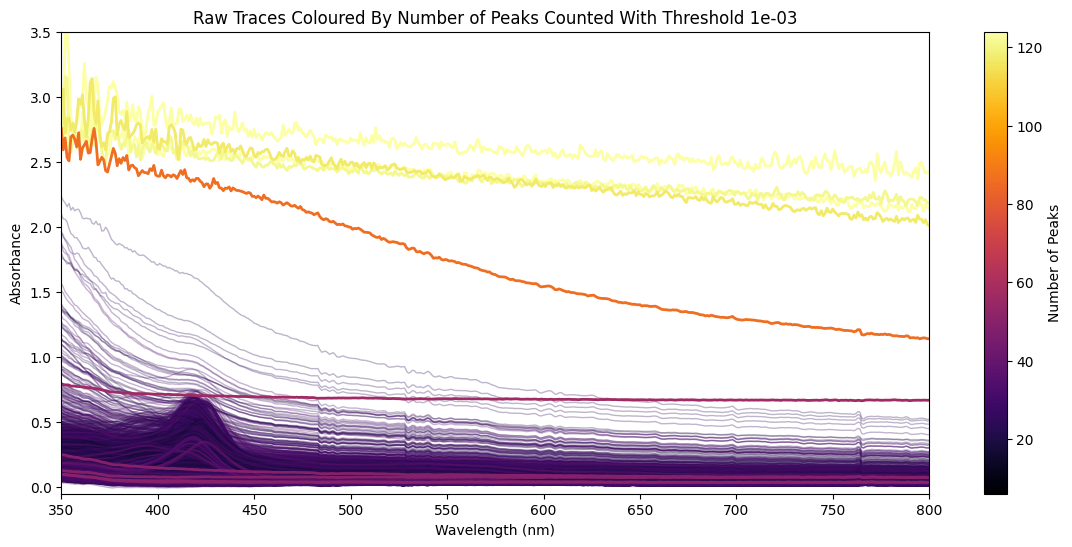

In [31]:
get_n_largest_idx = lambda n, a : np.argpartition(a, -n)[-n:]

thresh = 1e-3
peaks =  [
    signal.find_peaks(
        x=df_data.loc[i, 350:],
        height=None,
        threshold=thresh,
        distance=1,
        prominence=None,
        width=None,
    )[0]  for i in df_data.index
]

n_peaks = np.array([len(i) for i in peaks]) 
# peak_wavelengths = np.array([df_data.loc[:,350:].columns[i] for i in np.concatenate(peaks)])

n_peaks_colors = n_peaks - min(n_peaks)
n_peaks_colors = n_peaks_colors / max(n_peaks_colors)
n_peaks_colors = plt.cm.inferno(n_peaks_colors)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_traces(df_data[350:],
            colors=n_peaks_colors,
            lw=1,
            alpha=0.3,
            ax=ax,
            xlim=(350, 800),
           )

_worst = get_n_largest_idx(10, n_peaks)
plot_traces(df_data.loc[_worst, 350:],
            colors=n_peaks_colors[_worst],
            lw=2,
            alpha=1,
            ax=ax,
            xlim=(350, 800),
           )

add_cmap(fig,
         ax,
         vmin=min(n_peaks),
         vmax=max(n_peaks),
         label='Number of Peaks',
        )

plt.title(f'Raw Traces Coloured By Number of Peaks Counted With Threshold {thresh:.0e}')
plt.savefig(os.path.join(img_dir, 'raw-traces-color-n-peaks.png'))
plt.show()

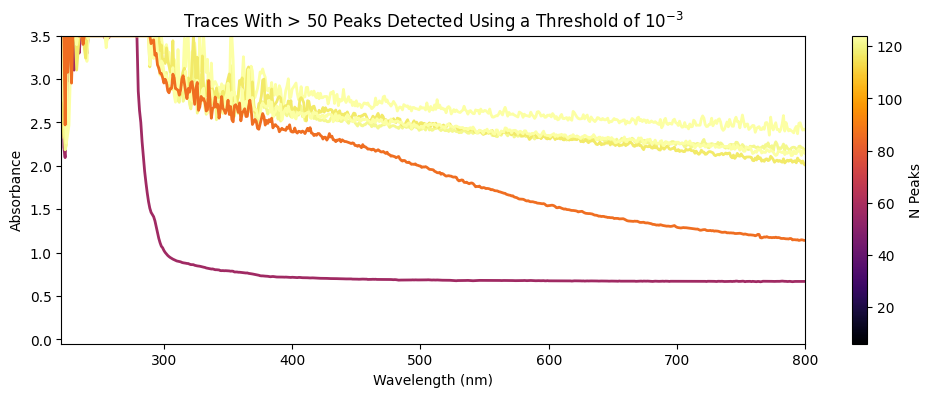

In [32]:
n_peaks = [len(i) for i in peaks]
n_peaks_ser = pd.Series(n_peaks)
#n_peaks_nlargest = n_peaks_ser.nlargest(10)
n_peaks_nlargest = n_peaks_ser.loc[n_peaks_ser > 50]

# plot_traces(df_data.iloc[, :])
# plt.show()
fig, ax = plt.subplots(1, 1, figsize=(12,4))

plot_traces(df_data.loc[n_peaks_nlargest.index, :],
            colors=n_peaks_colors[n_peaks_nlargest.index],
            lw=2,
            ax=ax,
           )

add_cmap(fig,
         ax,
         vmin=min(n_peaks),
         vmax=max(n_peaks),
         label='N Peaks',
        )

plt.title('Traces With > 50 Peaks Detected Using a Threshold of $10^{-3}$')
plt.show()

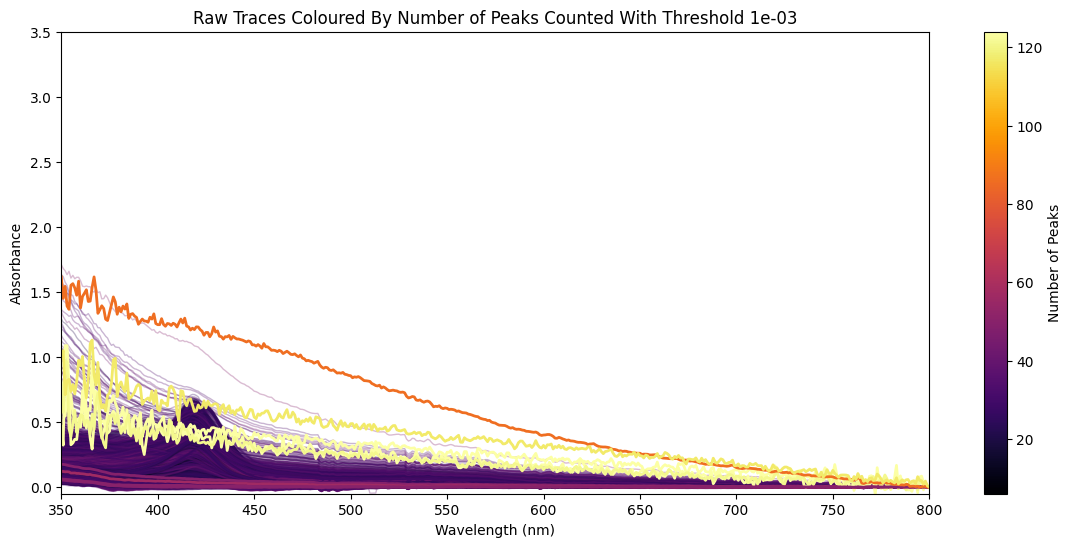

In [41]:

get_n_largest_idx = lambda n, a : np.argpartition(a, -n)[-n:]

thresh = 1e-3
peaks =  [
    signal.find_peaks(
        x=df_data.loc[i, 350:],
        height=None,
        threshold=thresh,
        distance=1,
        prominence=None,
        width=None,
    )[0]  for i in df_data.index
]

n_peaks = np.array([len(i) for i in peaks]) 
# peak_wavelengths = np.array([df_data.loc[:,350:].columns[i] for i in np.concatenate(peaks)])

n_peaks_colors = n_peaks - min(n_peaks)
n_peaks_colors = n_peaks_colors / max(n_peaks_colors)
n_peaks_colors = plt.cm.inferno(n_peaks_colors)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

df_data_ = df_data.loc[:, 350:].subtract(df_data[800], axis=0)

plot_traces(df_data_,
            colors=n_peaks_colors,
            lw=1,
            alpha=0.3,
            ax=ax,
            xlim=(350, 800),
           )

_worst = get_n_largest_idx(10, n_peaks)
plot_traces(df_data_.loc[_worst, :],
            colors=n_peaks_colors[_worst],
            lw=2,
            alpha=1,
            ax=ax,
            xlim=(350, 800),
           )

add_cmap(fig,
         ax,
         vmin=min(n_peaks),
         vmax=max(n_peaks),
         label='Number of Peaks',
        )

plt.title(f'Raw Traces Coloured By Number of Peaks Counted With Threshold {thresh:.0e}')
plt.savefig(os.path.join(img_dir, 'raw-traces-color-n-peaks-worrst-hl.png'))
plt.show()